In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'

import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


In [30]:
db.sort_values('n_pyr_putative',ascending=False)

data_dir_full  \
animal_name                                                        
e13_26m1    0  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26...   
e15_13f1    0  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            2  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            3  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
...                                                          ...   
e16_2m1     0  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m...   
e16_1f1     0  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f...   
e14_2m3     0  /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...   

                     sess_name animal_name.1        date  \
animal_name                                                
e13_26m1    0  e13_26m1_210913      e13_26m1  2021-09-13   
e15_13f1    0  e15_13f1_220117      e15_13f1  2022-01-17   
            1  e15_13f1_220118      e15_13f1  2022-01-18   
            2  e15_13f1_220119      e15_13f1  2022-01-19   
            3  e15_13f1_220120      e15_13f1  2022-01-20   
...                        ...           ...         ...   
e16_2m1     0   e16_2m1_201116       e16_2m1  2020-11-16   
e16_1f1     0   e16_1f1_200823       e16_1f1  2020-08-23   
            1   e16_1f1_200824       e16_1f1  2020-08-24   
e14_2m3     0   e14_2m3_201017       e14_2m3  2020-10-17   
            1   e14_2m3_201019       e14_2m3  2020-10-19   

                                    behavior  performance  ntrials  \
animal_name                                                          
e13_26m1    0                    alternation     0.956522       69   
e15_13f1    0                    alternation     0.617647       34   
            1   ['alternation' 'linearMaze']     0.740741       27   
            2  ['alternation' 'alternation']     0.721311       61   
            3   ['alternation' 'linearMaze']     0.800000       45   
...                                      ...          ...      ...   
e16_2m1     0                    alternation     0.636364       11   
e16_1f1     0                    alternation     0.631579       19   
            1                    alternation     0.571429       21   
e14_2m3     0                    alternation     0.615385       26   
            1                    alternation     0.863636       22   

               ngoodtrials  n_neurons  n_pyr_putative  owner   data_root  
animal_name                                                               
e13_26m1    0           69        482             422  roman  roman_data  
e15_13f1    0           34        376             333  roman  roman_data  
            1           27        363             318  roman  roman_data  
            2           61        343             288  roman  roman_data  
            3           45        303             248  roman  roman_data  
...                    ...        ...             ...    ...         ...  
e16_2m1     0           11         50              37  roman  roman_data  
e16_1f1     0           19         47              32  roman  roman_data  
            1           21         40              27  roman  roman_data  
e14_2m3     0           26         34              26  roman  roman_data  
            1           22         36              22  roman  roman_data  

[72 rows x 12 columns]

In [90]:
reload(dpp)

<module 'data_prep_pyn' from '/mnt/home/szheng/projects/util_code/data_prep_pyn.py'>

In [22]:
data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
# data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0] #0
# data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][19] #0

# data_dir_full = db.query('sess_name=="e15_13f1_220119"')['data_dir_full'][0]
# data_dir_full = db.query('sess_name=="e15_13f1_220120"')['data_dir_full'][0]
# data_dir_full = db.query('sess_name=="IZ33_580um_210315_sess9"')['data_dir_full'][0]
# data_dir_full = db.query('sess_name=="e15_10m1_200727"')['data_dir_full'][0]



# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses='*SessionPulses.Events.mat')
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']
# cell_metrics = mat_to_return['cell_metrics']

prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
# prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=True,extra_load=dict(sessionPulses='*SessionPulses.Events.mat',filtered='*thetaFiltered.lfp.mat'))
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df = dpp.group_into_trialtype(spk_beh_df)
# spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,nbins=100)
spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,bin_size=2.2,nbins=None)
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df']
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']


load *SessionPulses.Events.mat failed


In [86]:
reload(dpp)
beh_df=dpp.get_multi_maze_behavior_df(behavior)
beh_df = beh_df.reset_index()

> /mnt/home/szheng/projects/util_code/data_prep_pyn.py(932)find_tmaze_turns()
    930         pdb.set_trace()
    931 
--> 932         xyc_l = []
    933         lc_l = []
    934         ind_c_l = []

ipdb> n
> /mnt/home/szheng/projects/util_code/data_prep_pyn.py(933)find_tmaze_turns()
    931 
    932         xyc_l = []
--> 933         lc_l = []
    934         ind_c_l = []
    935         for xyc in xy_corners:

ipdb> n
> /mnt/home/szheng/projects/util_code/data_prep_pyn.py(934)find_tmaze_turns()
    932         xyc_l = []
    933         lc_l = []
--> 934         ind_c_l = []
    935         for xyc in xy_corners:
    936             # ind_c = find_closest_ind_2d(xyc,xy_sampled)

ipdb> n
> /mnt/home/szheng/projects/util_code/data_prep_pyn.py(935)find_tmaze_turns()
    933         lc_l = []
    934         ind_c_l = []
--> 935         for xyc in xy_corners:
    936             # ind_c = find_closest_ind_2d(xyc,xy_sampled)
    937             lin_c,ind_c = map_xy_to_lin(xyc,lin_vals,

ipdb> n
> /mnt/home/szheng/projects/util_code/data_prep_pyn.py(941)find_tmaze_turns()
    939             # lin_corners.append(lin_c)
    940             # for lc in lin_c:
--> 941             for lc,ic in zip(lin_c,ind_c):
    942                 if lc==lin_st_eps:
    943                     lc = val['lin'].min() # turn it back to min value

ipdb> n
> /mnt/home/szheng/projects/util_code/data_prep_pyn.py(935)find_tmaze_turns()
    933         lc_l = []
    934         ind_c_l = []
--> 935         for xyc in xy_corners:
    936             # ind_c = find_closest_ind_2d(xyc,xy_sampled)
    937             lin_c,ind_c = map_xy_to_lin(xyc,lin_vals,xy_sampled) # lin_vals and xy_sampled could be different, so this function might be weird; but it's not used anyway

ipdb> n
> /mnt/home/szheng/projects/util_code/data_prep_pyn.py(937)find_tmaze_turns()
    935         for xyc in xy_corners:
    936             # ind_c = find_closest_ind_2d(xyc,xy_sampled)
--> 937             lin_c,ind_c = map_x

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


> /mnt/home/szheng/projects/util_code/data_prep_pyn.py(930)find_tmaze_turns()
    928         y_bounds = hist_find_peaks(xy_sampled[:,1],n_peaks=2)
    929         xy_corners = np.array(list(itertools.product(x_bounds,y_bounds)))
--> 930         pdb.set_trace()
    931 
    932         xyc_l = []

ipdb> xy_corners
array([[46.39692898,  7.87545421],
       [46.39692898, 38.03407376],
       [ 7.44308708,  7.87545421],
       [ 7.44308708, 38.03407376]])
ipdb> xyc
array([49.56192857, 72.1150547 ])
ipdb> xy_corners
array([[46.39692898,  7.87545421],
       [46.39692898, 38.03407376],
       [ 7.44308708,  7.87545421],
       [ 7.44308708, 38.03407376]])
ipdb> xyc
array([49.56192857, 72.1150547 ])
ipdb> n
> /mnt/home/szheng/projects/util_code/data_prep_pyn.py(932)find_tmaze_turns()
    930         pdb.set_trace()
    931 
--> 932         xyc_l = []
    933         lc_l = []
    934         ind_c_l = []

ipdb> c


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


> /mnt/home/szheng/projects/util_code/data_prep_pyn.py(930)find_tmaze_turns()
    928         y_bounds = hist_find_peaks(xy_sampled[:,1],n_peaks=2)
    929         xy_corners = np.array(list(itertools.product(x_bounds,y_bounds)))
--> 930         pdb.set_trace()
    931 
    932         xyc_l = []

ipdb> c


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


> /mnt/home/szheng/projects/util_code/data_prep_pyn.py(932)find_tmaze_turns()
    930         pdb.set_trace()
    931 
--> 932         xyc_l = []
    933         lc_l = []
    934         ind_c_l = []

ipdb> c


KeyError: '[3] not in index'

In [73]:
import behavior_analysis as ba
reload(ba)
beh_df = ba.detect_offtrack_event(beh_df,find_turns_kws={},off_track_thresh = 4.,
            on_track_thresh = 1,edges_merge_time=0.4,st_ed_dist_thresh = 20.)


beh_df = ba.detect_speed_related_event(beh_df,exclude_key_l=['off_track_event'],
                        speed_key='speed_gauss',speed_thresh=1.,
                        compare_type='<=',
                        edges_merge_time = None,
                        event_key = 'pause_event',
                        )

beh_df = ba.detect_speed_related_event(beh_df,exclude_key_l=['off_track_event','pause_event'],
                        speed_key='v_gauss',speed_thresh=1.,
                        compare_type='>',
                        edges_merge_time = None,
                        event_key = 'directed_locomotion',
                        )

beh_df = ba.detect_speed_related_event(beh_df,exclude_key_l=['off_track_event','pause_event','directed_locomotion'],
                        speed_key='speed_gauss',speed_thresh=[1,5],
                        compare_type='between',
                        edges_merge_time = None,
                        event_key = 'low_speed',
                        )

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) 

<IPython.core.display.Javascript object>


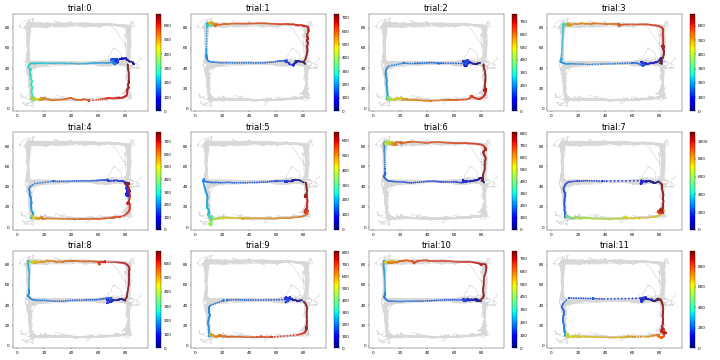

In [3]:
%matplotlib notebook
# off track event
import behavior_analysis as ba
reload(ba)
trial_l = list(range(12))
nplots = len(trial_l)
fig,axs=ph.subplots_wrapper(nplots)
beh_df_sub = beh_df.query('task_index==0')
for ii,tr in enumerate(trial_l): 
    ax = axs.ravel()[ii]
    one_chunk = beh_df_sub.query('trial==@tr')
    

    fig,ax=ba.plot_one_headscan(beh_df_sub,one_chunk,fig=fig,ax=ax)
    ax.set_title(f'trial:{tr}')
plt.tight_layout()

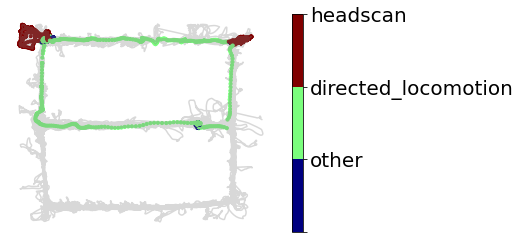

In [41]:
import behavior_analysis as ba
reload(ba)
beh_df_sub = beh_df.query('task_index==0')
# ax = axs.ravel()[ii]
tr=6
one_chunk = beh_df_sub.query('trial==@tr')
# colors =  one_chunk['pause_event'].astype(int) * 1 + one_chunk['low_speed'].astype(int) * 2 +  \
#         one_chunk['directed_locomotion'].astype(int) * 3 + one_chunk['off_track_event'].astype(int)  * 4

colors = one_chunk['directed_locomotion'].astype(int) * 1 + one_chunk['off_track_event'].astype(int)  * 2


fig,ax,cbar=ba.plot_one_headscan(beh_df_sub,one_chunk,colors=colors,cmin=0,cmax=2,color_discrete=True,
                        cbar_tick_labels=['','other','directed_locomotion','headscan'],fig=None,ax=None
                       )
cbar.ax.tick_params(labelsize=20)
ax.axis('off')
figdir='/mnt/home/szheng/ceph/place_variability/fig/paper/figure2'
figfn = 'headscan_schematic'
ph.save_given_name(fig,figfn,figdir=figdir)

<IPython.core.display.Javascript object>


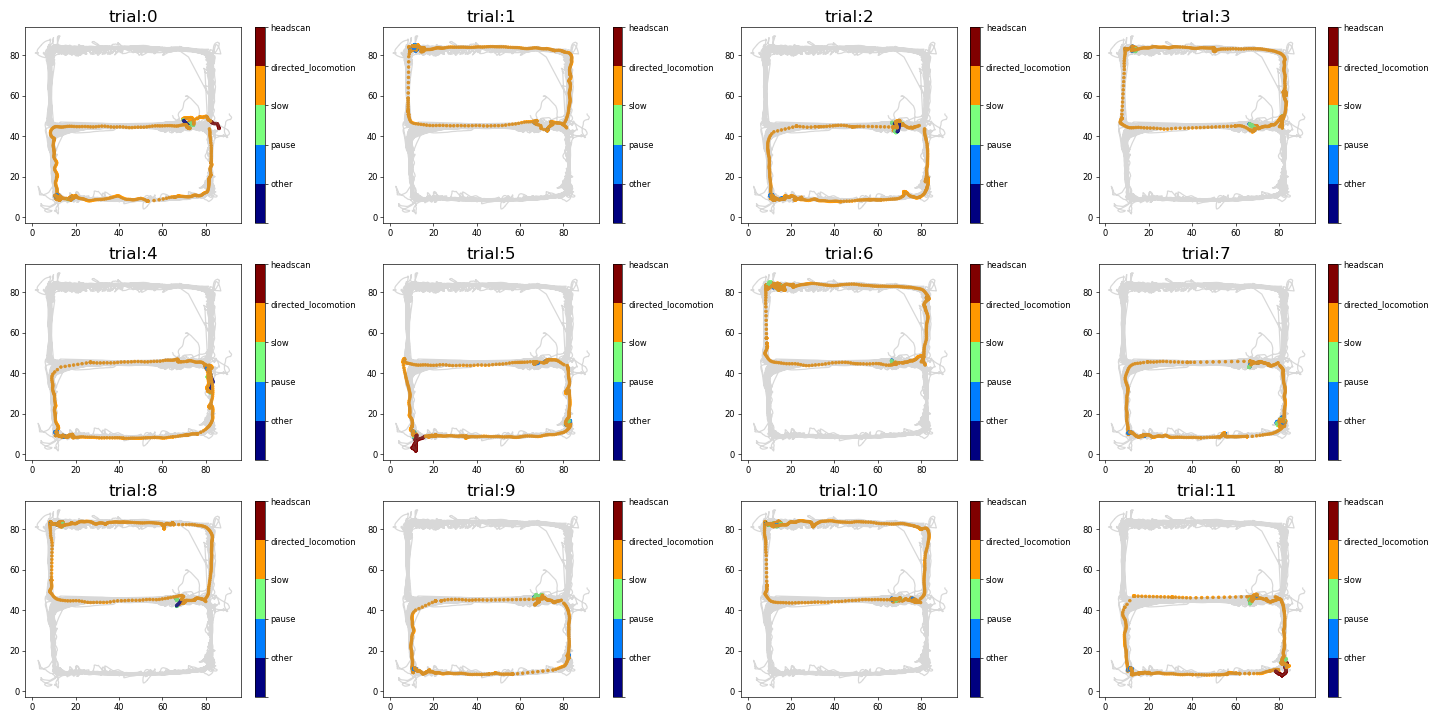

In [4]:
%matplotlib notebook
# off track event
import behavior_analysis as ba
reload(ba)
trial_l = list(range(12))
nplots = len(trial_l)
fig,axs=ph.subplots_wrapper(nplots)
beh_df_sub = beh_df.query('task_index==0')
for ii,tr in enumerate(trial_l): 
    ax = axs.ravel()[ii]
    one_chunk = beh_df_sub.query('trial==@tr')
    colors =  one_chunk['pause_event'].astype(int) * 1 + one_chunk['low_speed'].astype(int) * 2 +  \
            one_chunk['directed_locomotion'].astype(int) * 3 + one_chunk['off_track_event'].astype(int)  * 4

    fig,ax=ba.plot_one_headscan(beh_df_sub,one_chunk,colors=colors,cmin=0,cmax=4,color_discrete=True,
                            cbar_tick_labels=['','other','pause','slow','directed_locomotion','headscan'],fig=fig,ax=ax
                           )
    ax.set_title(f'trial:{tr}')
plt.tight_layout()

<IPython.core.display.Javascript object>


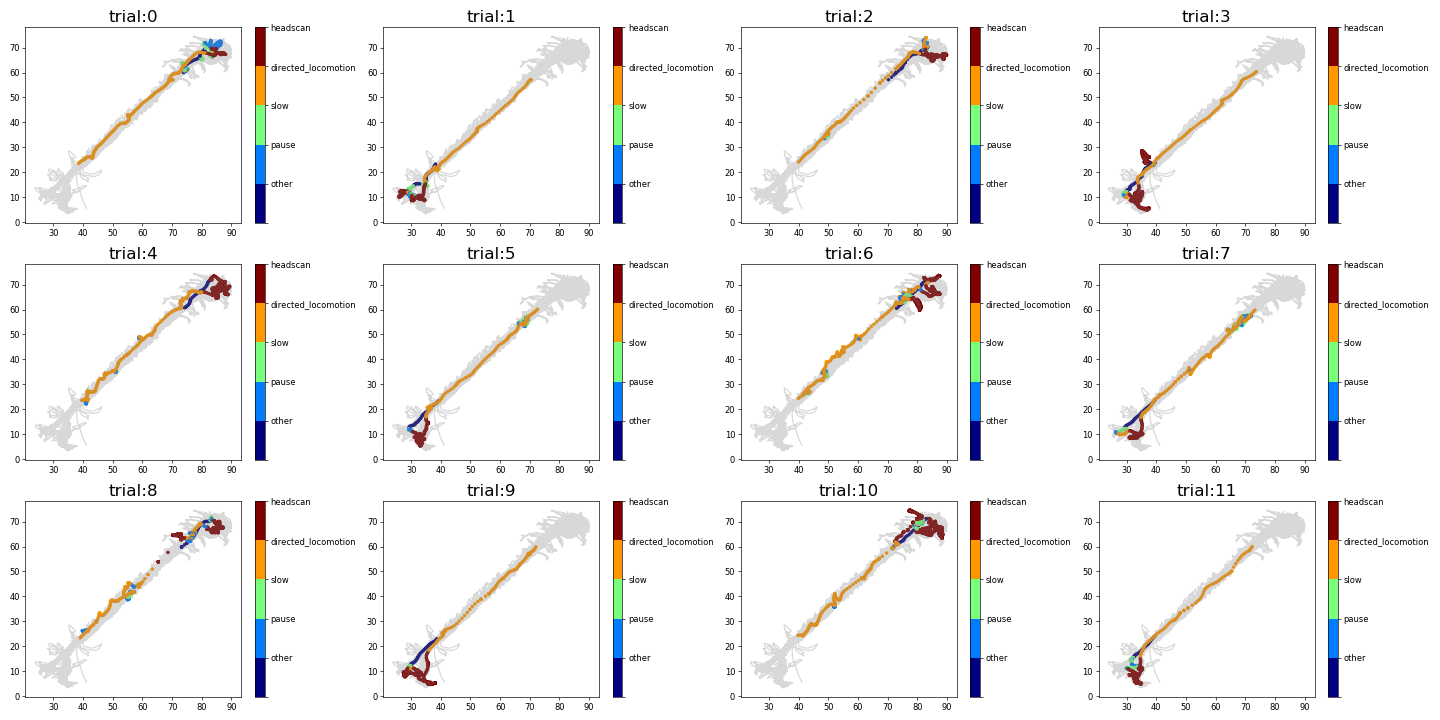

In [78]:
%matplotlib notebook
# off track event
import behavior_analysis as ba
reload(ba)
trial_l = list(range(12))
nplots = len(trial_l)
fig,axs=ph.subplots_wrapper(nplots)
beh_df_sub = beh_df.query('task_index==1')
for ii,tr in enumerate(trial_l): 
    ax = axs.ravel()[ii]
    one_chunk = beh_df_sub.query('trial==@tr')
    one_chunk = one_chunk.fillna(0)
    colors =  one_chunk['pause_event'].astype(int) * 1 + one_chunk['low_speed'].astype(int) * 2 +  \
            one_chunk['directed_locomotion'].astype(int) * 3 + one_chunk['off_track_event'].astype(int)  * 4

    fig,ax=ba.plot_one_headscan(beh_df_sub,one_chunk,colors=colors,cmin=0,cmax=4,color_discrete=True,
                            cbar_tick_labels=['','other','pause','slow','directed_locomotion','headscan'],fig=fig,ax=ax
                           )
    ax.set_title(f'trial:{tr}')
plt.tight_layout()

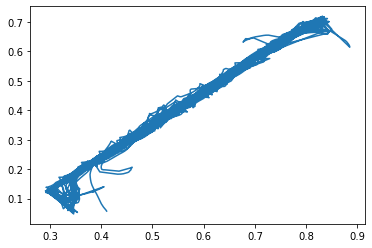

In [53]:
lin_highsp = beh_df_sub.query('speed_gauss>5')
plt.plot(lin_highsp['x'],lin_highsp['y'])

In [62]:
reload(dpp)
dpp.get_xy_samples_from_lin_one(beh_df_sub)

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) /

array([[0.29806177, 0.11729064],
       [0.30169316, 0.1192757 ],
       [0.30370647, 0.12313137],
       [0.30600247, 0.12698704],
       [0.3076091 , 0.13049651],
       [0.31034334, 0.13369531],
       [0.31291658, 0.13700757],
       [0.31519697, 0.14008513],
       [0.31755555, 0.14303157],
       [0.32003485, 0.14586421],
       [0.32320954, 0.1488828 ],
       [0.32578278, 0.15187373],
       [0.32835602, 0.1547496 ],
       [0.33210247, 0.15718955],
       [0.3335025 , 0.16101802],
       [0.33642946, 0.16360612],
       [0.33765054, 0.16742614],
       [0.3406819 , 0.17060563],
       [0.34177415, 0.17459969],
       [0.34448516, 0.17708994],
       [0.34660218, 0.18115226],
       [0.3490632 , 0.18420087],
       [0.35208937, 0.18720482],
       [0.35424899, 0.19014648],
       [0.35697263, 0.19334452],
       [0.35930235, 0.19628446],
       [0.36176735, 0.1991752 ],
       [0.36467741, 0.20216434],
       [0.36641675, 0.20603199],
       [0.36976996, 0.20820423],
       [0.

In [57]:
from scipy.interpolate import interp1d
val = beh_df_sub
speed_key = 'speed_gauss'
speed_thresh = 10.
val = val.loc[val[speed_key]>speed_thresh]
lin_st_eps = 1e-3
n_lin = 200
val_trial = val.groupby('trial')
xy_sampled_median = []
lin_vals = np.linspace(val['lin'].min()+lin_st_eps,val['lin'].max(),n_lin)
for tr, vt in val_trial:
    lin_one = vt['lin'].values

    lin_to_xy_func = interp1d(lin_one,vt[['x','y']].values,axis=0,fill_value='extrapolate')

    xy_sampled = lin_to_xy_func(lin_vals)
    xy_sampled_median.append(xy_sampled)
xy_sampled_median = np.array(xy_sampled_median)
xy_sampled_median = np.nanmedian(xy_sampled_median,axis=0)
xy_sampled = xy_sampled_median
ma=np.isnan(xy_sampled).any(axis=1)
xy_sampled  = xy_sampled[~ma]

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) /

In [44]:
dist_from_magnified_xy= np.linalg.norm(((beh_df_sub[['x','y']] * 100).diff()),axis=1)
dist_from_lin = beh_df_sub['lin'].diff()

In [93]:
bdf=beh_df
xy_l = bdf[['x','y']].values
xy_sampled_all=np.concatenate(list(xy_sampled_d.values()),axis=0)
dist = ba.get_dist_to_maze(xy_l,xy_sampled_all)


<IPython.core.display.Javascript object>


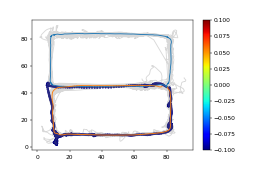

In [86]:
beh_df_sub = beh_df.query('task_index==0')
one_chunk = beh_df_sub.query('trial==5')
colors = one_chunk['off_track'].astype(int)
fig,ax=ba.plot_one_headscan(beh_df_sub,one_chunk,colors=colors)
for k,val in xy_sampled_d.items():
    ax.plot(val[:,0],val[:,1])


<IPython.core.display.Javascript object>


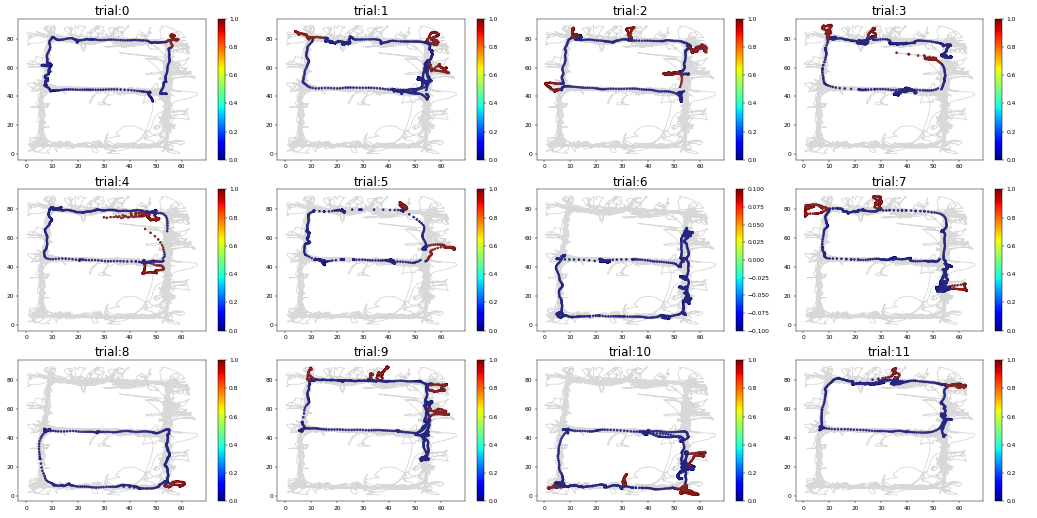

In [42]:
%matplotlib notebook
# off track event
import behavior_analysis as ba
reload(ba)
trial_l = list(range(12))
nplots = len(trial_l)
fig,axs=ph.subplots_wrapper(nplots)
beh_df_sub = beh_df.query('task_index==1')
for ii,tr in enumerate(trial_l): 
    ax = axs.ravel()[ii]
    one_chunk = beh_df_sub.query('trial==@tr')
    colors = one_chunk['off_track_event'].astype(int)
    fig,ax=ba.plot_one_headscan(beh_df_sub,one_chunk,colors=colors,fig=fig,ax=ax)
    ax.set_title(f'trial:{tr}')
plt.tight_layout()

# fix getting tmaze samples

In [101]:
from scipy.interpolate import interp1d
speed_key = 'speed_gauss'
speed_thresh = 10
val = beh_df.query('task_index==0&visitedArm==0')
val = val.loc[val[speed_key]>speed_thresh]        
lin_one = val['lin'].values
lin_st_eps = 0.001
n_lin = 200
lin_to_xy_func = interp1d(lin_one,val[['x','y']].values,axis=0)
lin_vals = np.linspace(lin_one.min()+lin_st_eps,lin_one.max(),n_lin)
xy_sampled = lin_to_xy_func(lin_vals)

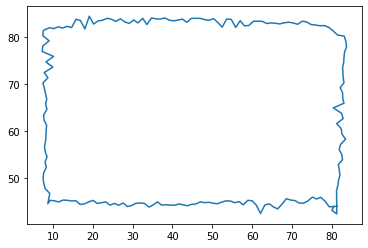

In [102]:
%matplotlib inline
plt.plot(xy_sampled[:,0],xy_sampled[:,1])

In [113]:
val = val.loc[val[speed_key]>speed_thresh]        
val_trial = val.groupby('trial')
xy_sampled_avg = []
for tr, vt in val_trial:
    lin_one = vt['lin'].values
    lin_st_eps = 0.001
    n_lin = 200
    lin_to_xy_func = interp1d(lin_one,vt[['x','y']].values,axis=0)
    lin_vals = np.linspace(lin_one.min()+lin_st_eps,lin_one.max(),n_lin)
    xy_sampled_one = lin_to_xy_func(lin_vals)
    xy_sampled_avg.append(xy_sampled_one)
xy_sampled_avg = np.array(xy_sampled_avg)
xy_sampled_avg = np.median(xy_sampled_avg,axis=0)

In [105]:
np.isnan(xy_sampled_avg).sum()

0

In [111]:
np.median([np.inf,2,3,4,5])

4.0

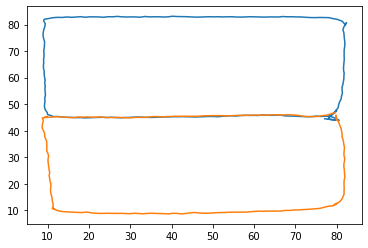

In [55]:
%matplotlib inline
for k,val in xy_sampled_d.items():
    plt.plot(val[:,0],val[:,1])


# try: IQR test

In [137]:
beh_df_sub = beh_df.query('task_index==0')

In [138]:
%%time
highspeed_thresh = 5.
beh_df_highspeed = beh_df_sub.loc[beh_df_sub['speed_gauss'] > highspeed_thresh]
buffer_time = 4
dt = 0.033
buffer_nbins = int(buffer_time / dt)
off_track_l = []
on_track_l = []
off_track_dist_hard_thresh = 0#3

dist_buffer = beh_df_highspeed.iloc[:buffer_nbins]['dist_to_maze']
for k,row in beh_df_sub.iterrows():
    if k<buffer_nbins * 2:
        dist_buffer = dist_buffer
    else:
        new_buffer = beh_df_highspeed.loc[(k-buffer_nbins):k]['dist_to_maze']
        if len(new_buffer) < buffer_nbins/2: # if new buffer size small, use old buffer; just for simplicity
            dist_buffer = dist_buffer
        
    dist_buffer_low = np.quantile(dist_buffer,0.25)
    dist_buffer_high = np.quantile(dist_buffer,0.75)
    dist_buffer_high_for_on = np.quantile(dist_buffer,0.5)
    iqr = dist_buffer_high-dist_buffer_low
#     ci_high = dist_buffer_high+iqr / 2
    ci_high = np.quantile(dist_buffer,0.75)
    off_track = (row['dist_to_maze'] > ci_high) & (row['dist_to_maze'] > off_track_dist_hard_thresh)
    off_track_l.append(off_track)
    on_track = row['dist_to_maze'] <= dist_buffer_high_for_on
    on_track_l.append(on_track)
beh_df_sub['off_track_iqr'] = off_track_l
beh_df_sub['on_track_iqr'] = on_track_l

CPU times: user 36.6 s, sys: 37.5 ms, total: 36.6 s
Wall time: 36.6 s


<timed exec>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [85]:

import behavior_analysis
reload(behavior_analysis)
from behavior_analysis import *

In [139]:
edges_merge_time = 0.4
st_ed_dist_thresh = 20
xy_l = beh_df_sub[['x','y']].values

In [140]:
off_track_key = 'off_track_iqr'
on_track_key = 'on_track_iqr'
off_track_event_key = 'off_track_event_iqr'
off_track_edges = get_mask_edges(beh_df_sub[off_track_key])
edge_merge_nbins = int(edges_merge_time / dt)
off_track_edges_merged = merge_edges(off_track_edges,thresh=edge_merge_nbins)
on_track_edges = get_mask_edges(beh_df_sub[on_track_key])
# extend off track to on
off_track_extended_st_ed = extend_off_track_to_on(off_track_edges_merged,on_track_edges)

# filter too short ones
ma = (off_track_extended_st_ed[:,1]-off_track_extended_st_ed[:,0]) >= edge_merge_nbins
off_track_extended_st_ed = off_track_extended_st_ed[ma]

# filter st ed too far away
st_ed_dist = np.linalg.norm(xy_l[off_track_extended_st_ed[:,0]] - xy_l[off_track_extended_st_ed[:,1]],axis=1)
off_track_extended_st_ed = off_track_extended_st_ed[st_ed_dist <= st_ed_dist_thresh]

# fill in the event
off_track_event = np.zeros(beh_df_sub.shape[0],dtype=bool)
for st,ed in off_track_extended_st_ed:
    off_track_event[st:ed] = 1
beh_df_sub[off_track_event_key] = off_track_event

/tmp/ipykernel_166891/2070847938.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beh_df_sub[off_track_event_key] = off_track_event


<IPython.core.display.Javascript object>


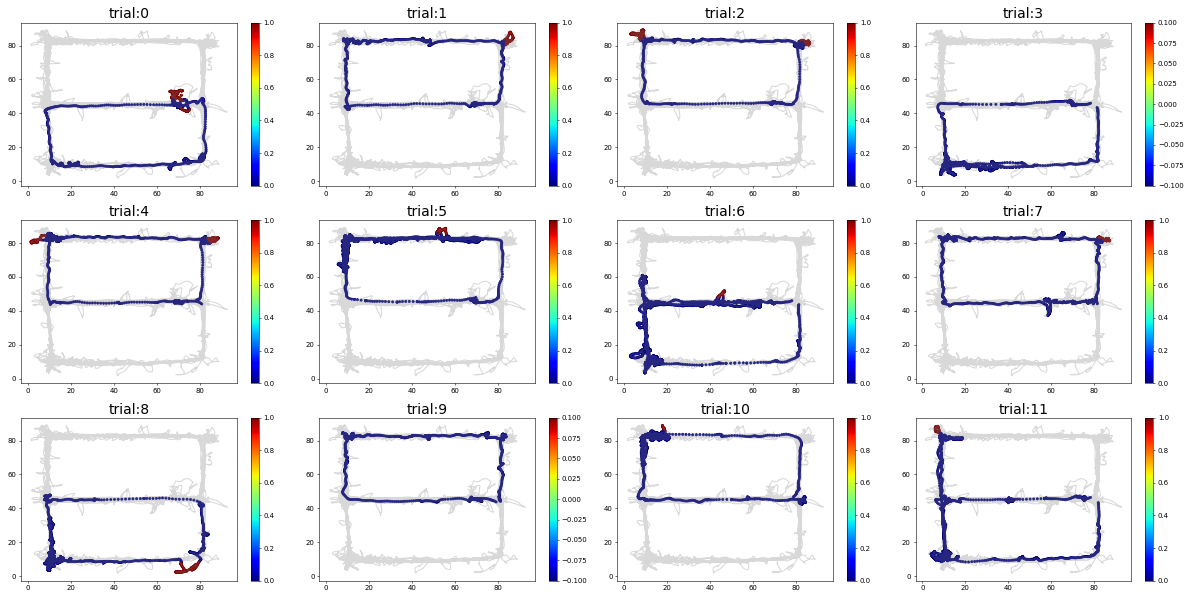

In [141]:
%matplotlib notebook
# off track event
import behavior_analysis as ba
reload(ba)
trial_l = list(range(12))
nplots = len(trial_l)
fig,axs=ph.subplots_wrapper(nplots)
for ii,tr in enumerate(trial_l): 
    ax = axs.ravel()[ii]
    one_chunk = beh_df_sub.query('trial==@tr')
    colors = one_chunk['off_track_event_iqr'].astype(int)
    fig,ax=ba.plot_one_headscan(beh_df_sub,one_chunk,colors=colors,fig=fig,ax=ax)
    ax.set_title(f'trial:{tr}')
plt.tight_layout()

<IPython.core.display.Javascript object>


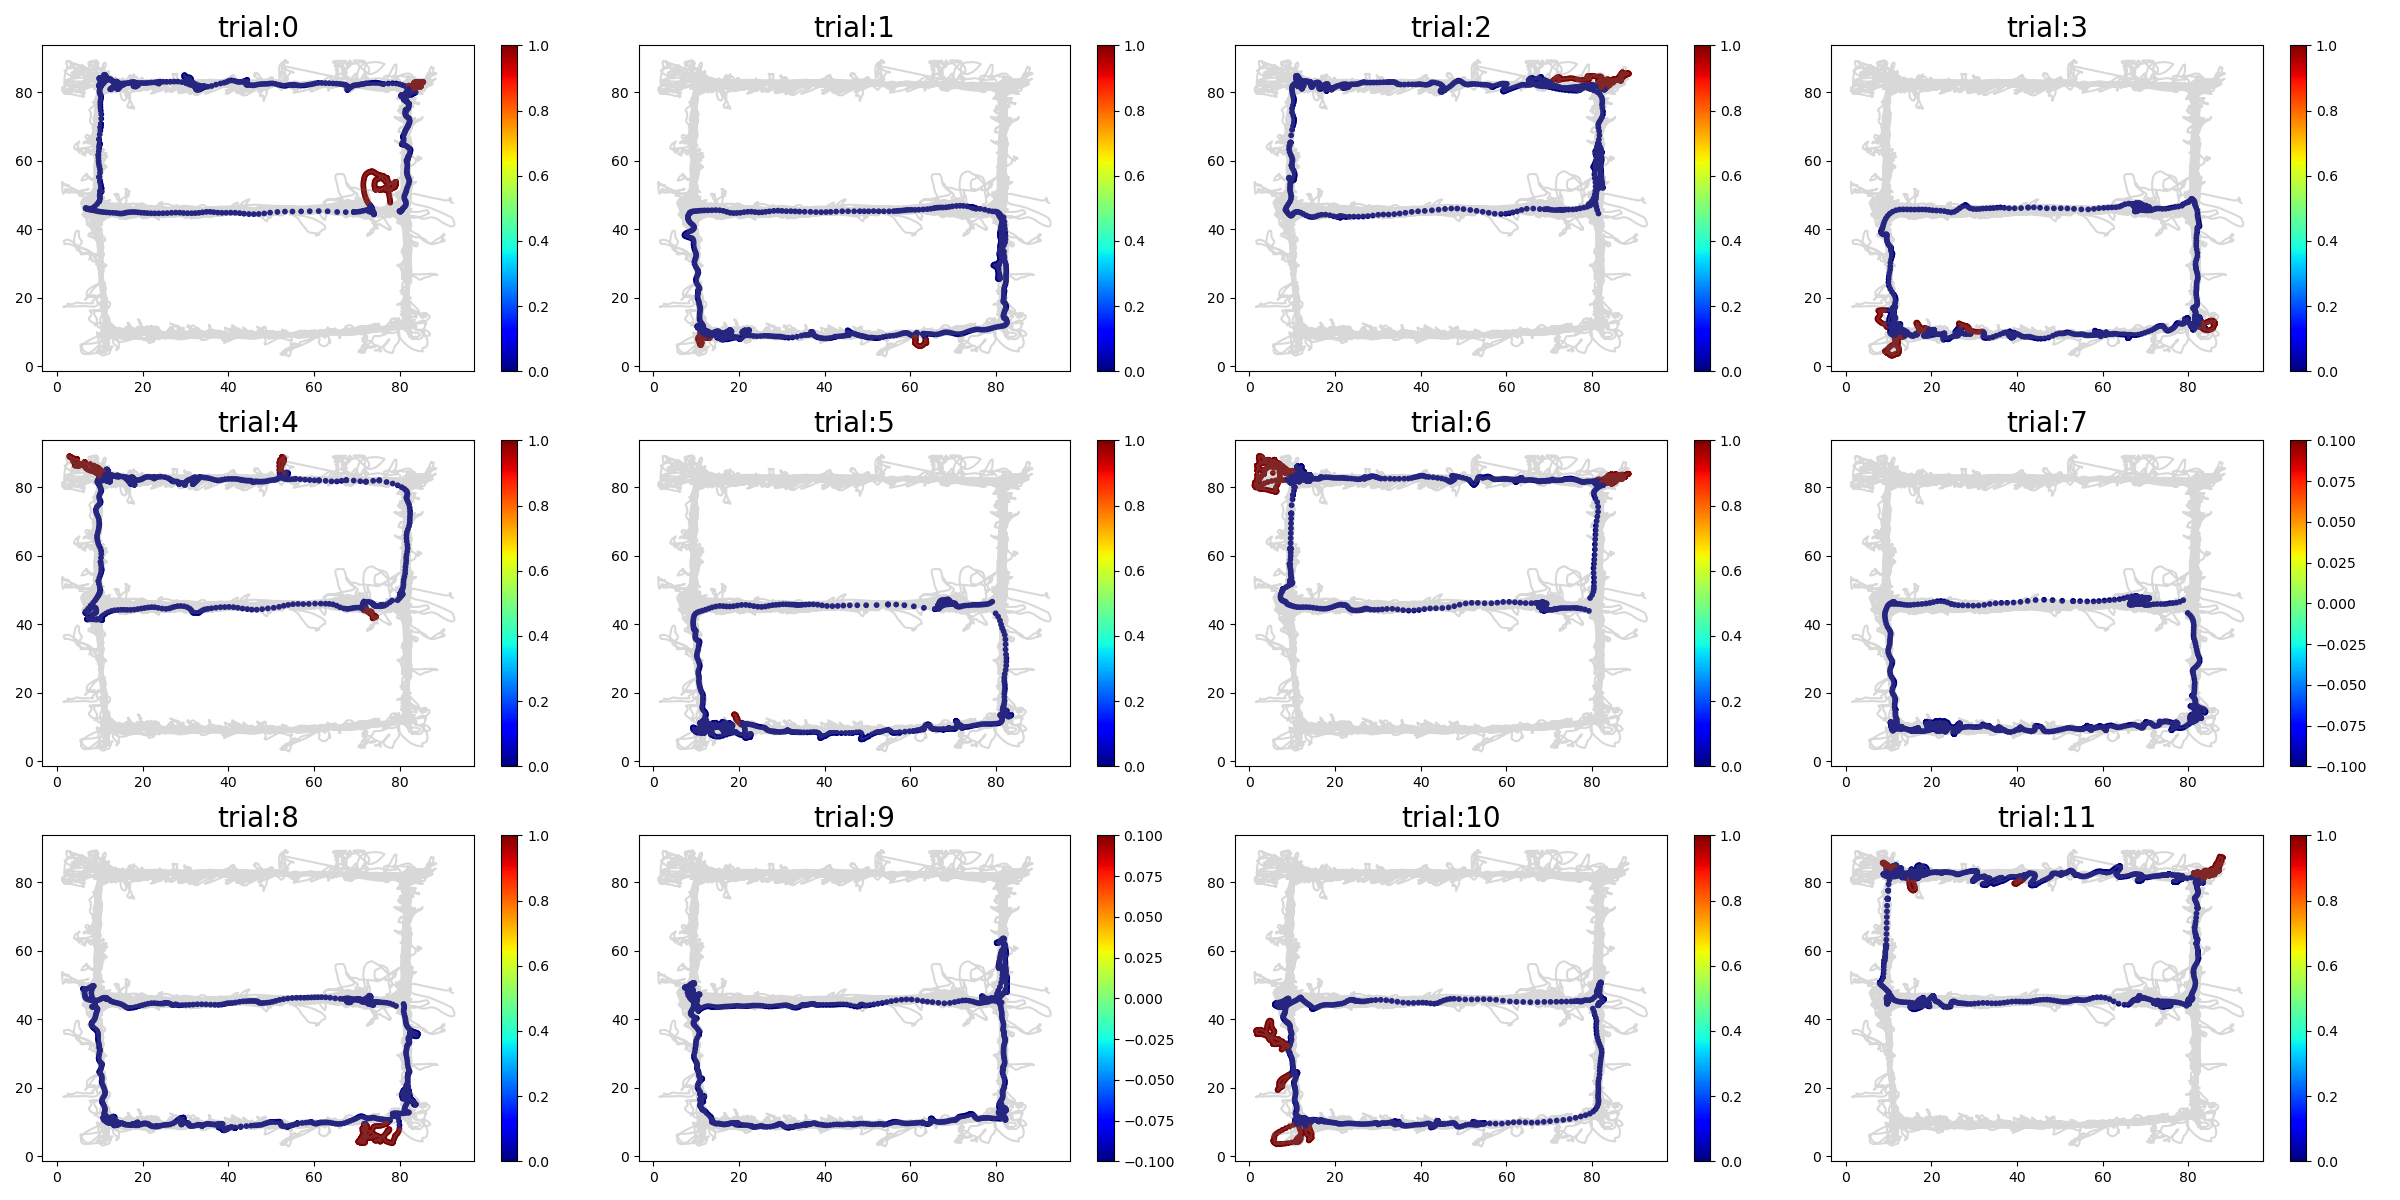

In [43]:
%matplotlib notebook
# off track event
import behavior_analysis as ba
reload(ba)
trial_l = list(range(12))
nplots = len(trial_l)
fig,axs=ph.subplots_wrapper(nplots)
for ii,tr in enumerate(trial_l): 
    ax = axs.ravel()[ii]
    one_chunk = beh_df.query('trial==@tr')
    colors = one_chunk['off_track_event_iqr'].astype(int)
    fig,ax=ba.plot_one_headscan(beh_df,one_chunk,colors=colors,fig=fig,ax=ax)
    ax.set_title(f'trial:{tr}')
plt.tight_layout()

# redo direction

## first try seperating trial types, basically ignoring those over crossing

In [330]:
bdf =  beh_df.query('task_index==0')

In [422]:
kwargs_ = {'n_lin':200,'speed_key':'speed_gauss','speed_thresh':10,'key_post_fix':'gauss'}

corners_d,xy_sampled_d,segment_d=dpp.find_tmaze_turns(beh_df,n_lin=kwargs_['n_lin'],speed_key=kwargs_['speed_key'],speed_thresh=kwargs_['speed_thresh'])
v_dir_d = dpp.get_v_direction(corners_d,thresh = 5.) # within thresh, considered no change
gpb = beh_df.groupby('trial_type')
post_fix_key = kwargs_['key_post_fix']
vx_key = f'vx_{post_fix_key}'
vy_key = f'vy_{post_fix_key}'
v_key = f'v_{post_fix_key}'
speed_key = kwargs_['speed_key']


for tt, val in gpb:
#     if tt==(0,1):
        
    v_dir = v_dir_d[tt]
    val_xy_to_sample_dist = cdist(val[['x','y']].values,xy_sampled_d[tt])
    inds = np.argmin(val_xy_to_sample_dist,axis=1)
    seg_l = segment_d[tt][inds]
    x_sign_l = v_dir.loc[seg_l,'x_sign'].values
    y_sign_l = v_dir.loc[seg_l,'y_sign'].values
    x_coord_l = corners_d[tt].loc[seg_l,'x'].values
    y_coord_l = corners_d[tt].loc[seg_l,'y'].values

    v_aligned = val[vx_key] * x_sign_l + val[vy_key] * y_sign_l # assuming sign: one +-1, the other 0
    # v_off = val['vx_kalman'] * (x_sign_l==0) + val['vy_kalman'] * (y_sign_l==0) # assuming sign: one +-1, the other 0

    # deal with close to corner cases
    dist_to_corners = cdist(val[['x','y']].values,corners_d[tt].loc[0:3,['x','y']])
    dist_to_corners_argmin = np.argmin(dist_to_corners,axis=1)
    dist_to_corners_min = np.min(dist_to_corners,axis=1)
    dist_to_corner_thresh = 5
    close_to_corner = dist_to_corners_min < dist_to_corner_thresh

    seg_l_prev = (dist_to_corners_argmin - 1) % 4
    seg_l_next = (dist_to_corners_argmin) % 4

    x_sign_l_prev = v_dir.loc[seg_l_prev,'x_sign'].values
    y_sign_l_prev = v_dir.loc[seg_l_prev,'y_sign'].values
    v_aligned_prev = val[vx_key] * x_sign_l_prev + val[vy_key] * y_sign_l_prev

    x_sign_l_next = v_dir.loc[seg_l_next,'x_sign'].values
    y_sign_l_next = v_dir.loc[seg_l_next,'y_sign'].values
    v_aligned_next = val[vx_key] * x_sign_l_next + val[vy_key] * y_sign_l_next
    aligned_close_to_corner = ((np.sign(v_aligned_prev) + np.sign(v_aligned_next)) >= 0).astype(int) # lenient: if one direction is positive, count as positive
    aligned_close_to_corner = 2*(aligned_close_to_corner - 1/2)
    aligned_close_to_corner = aligned_close_to_corner[close_to_corner]



    aligned = np.sign(v_aligned)
    aligned[close_to_corner] = aligned_close_to_corner

    v_kalman = val[speed_key] * aligned
    # distance off the track
    # coord_off = (val['x']-x_coord_l) * (x_sign_l==0) + (val['y']-y_coord_l) * (y_sign_l==0) # select x/y as where x/y_sign==0 as the baseline coordinate to compute deviation 

    beh_df.loc[val.index,'segment'] = seg_l
    beh_df.loc[val.index,v_key] = v_kalman


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [410]:
v_aligned_prev.loc[3795]

-11.188091710985383

In [411]:
v_aligned_next.loc[3795]

10.733095319233096

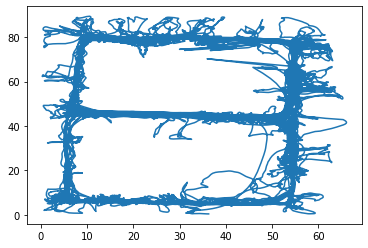

In [370]:
plt.plot(beh_df.query('task_index==1')['x'],beh_df.query('task_index==1')['y'])

<AxesSubplot:>

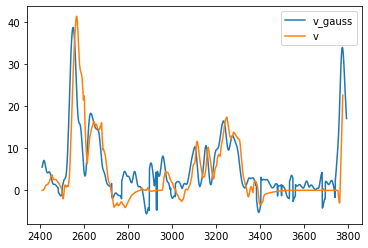

In [423]:
beh_df.query('task_index==0&trial==2')[['v_gauss','v']].plot()

In [393]:
beh_df['v_lin_raw'] = beh_df['lin'].diff()/dt

(-10.0, 40.0)

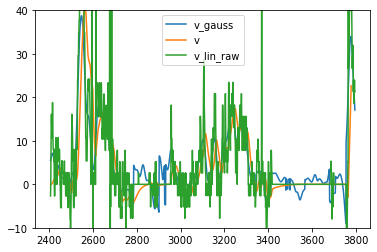

In [396]:
ax=beh_df.query('task_index==0&trial==2')[['v_gauss','v','v_lin_raw']].plot()
ax.set_ylim([-10,40])

In [421]:
one_chunk = beh_df.query('task_index==0&trial==3')
ma=(one_chunk['v_gauss'] < -2) & (one_chunk['v'] >0)
one_chunk.loc[ma]
one_chunk.loc[ma,['lin','x','y','vx_gauss','vy_gauss','v_gauss','v','trial_type','segment','v_lin_raw']]

,lin,x,y,vx_gauss,vy_gauss,v_gauss,v,trial_type,segment,v_lin_raw
3867,11.786506,69.097644,46.722955,1.128982,-1.734327,-2.069417,0.406601,"(0, 1.0)",0.0,-2.685465
3868,11.520645,69.296368,46.529205,1.189167,-1.828238,-2.180956,0.227245,"(0, 1.0)",0.0,-8.056395
3869,11.432025,69.439408,46.317872,1.234778,-1.905393,-2.270507,0.050201,"(0, 1.0)",0.0,-2.685465
4265,115.047986,14.128496,9.679761,-2.050909,0.968516,-2.268095,1.212591,"(0, 1.0)",2.0,0.000000
4266,114.956809,14.083152,9.683605,-2.391325,1.125202,-2.642823,1.114060,"(0, 1.0)",2.0,-2.762936
...,...,...,...,...,...,...,...,...,...,...
5516,119.515653,18.344946,11.142830,-6.253889,0.963238,-6.327635,2.618838,"(0, 1.0)",2.0,-5.525871
5517,119.333299,18.163978,11.037927,-6.480811,0.752566,-6.524360,2.122913,"(0, 1.0)",2.0,-5.525871
5518,119.059769,17.930507,10.947379,-6.664704,0.540223,-6.686562,1.592305,"(0, 1.0)",2.0,-8.288807
5519,118.603884,17.539845,10.963456,-6.798796,0.330487,-6.806823,0.955546,"(0, 1.0)",2.0,-13.814678


In [383]:
aligned_close_to_corner = np.sign(v_aligned_prev + v_aligned_next)[close_to_corner]
aligned[close_to_corner] = aligned_close_to_corner

In [401]:
close_to_corner[3795]

True

In [399]:
aligned_close_to_corner.loc[3795]

KeyError: 3795

In [ ]:
seg_l = segment_d[tt][inds]

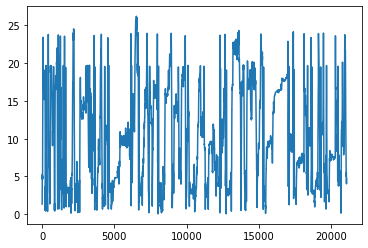

In [365]:
plt.plot(dist_to_corners_min)

In [354]:
dist_to_corners_min.shape

(21064, 21064)

<AxesSubplot:>

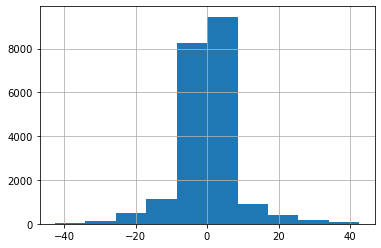

In [343]:
%matplotlib inline
(val[vx_key] - val[vy_key]).hist()

In [ ]:
corners_d,xy_sampled_d,segment_d=dpp.find_tmaze_turns(bdf,**find_turns_kws_)
xy_sampled_all = np.concatenate(list(xy_sampled_d.values()),axis=0)
